<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA1: Deep Reinforcement Learning

#### AUTOR: Mario Ubierna San Mamés
 

En esta práctica se hará un estudio sobre el entorno **highway-env**, donde inicialmente se realizará una exploración sobre el entorno, posteriormente implementaremos un agente DQN y finalmente mejoraremos el primer agente implementado

## 0. Contexto

**Highway-env** es un problema de conducción autónoma, donde tenemos múltiples carriles y varios coches transitando. Nuestro objetivo es que el agente sea capaz de controlar el vehículo con el fin de:

- Evitar colisiones con otros vehículos.
- Tener la máxima velocidad posible.
- Mantenerse en el carril derecho lo más posible.

El entorno se considera superado cuando en el tiempo de observación máximo establecido, se han verificado las tres condiciones anteriores.

![Alt Text](https://raw.githubusercontent.com/eleurent/highway-env/gh-media/docs/media/highway-env.gif?raw=true)

## 1. Entorno

Lo primero de todo es cargar las librerías necesarias:

In [1]:
import gym
import highway_env
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import time

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.1 (0.5 ptos) - </strong> Exploración del entorno y representación de una ejecución aleatoria:
</div>

#### Exploración del entorno

Carga del entorno:

In [2]:
# Definimos el entorno
env = gym.make("highway-v0")

Información básica del entorno:

In [3]:
print("El espacio de acciones es {} ".format(env.action_space))
print("La dimensión del espacio de acciones es: {}".format(env.action_space.n))
# print("Las acciones por defecto son {}".format(str(env.action_type.actions_indexes)))
print("El espacio de observaciones es {} ".format(env.observation_space))
print("La dimensión del espacio de estados: {}".format(env.observation_space.shape[0]))
print("El rango de recompensas es {} ".format(env.reward_range))

El espacio de acciones es Discrete(5) 
La dimensión del espacio de acciones es: 5
El espacio de observaciones es Box([[-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]], [[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]], (5, 5), float32) 
La dimensión del espacio de estados: 5
El rango de recompensas es (-inf, inf) 


De la anterior ejecución podemos observar que, por defecto tanto la dimensión del espacio de acciones como de estados es 5. Estos valores vienen predefinidos a la hora de cargar el entorno **highway-v0**.  
  
Para saber más sobre la configuración por defecto del entorno ejecutamos la siguiente instrucción:

In [4]:
env.env.default_config()

{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 4,
 'vehicles_count': 50,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 40,
 'ego_spacing': 2,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'offroad_terminal': False}

Como podemos ver obtenemos la siguiente información:  
- El tipo de observación es Kinematics, esto lo que significa es que el espacio de estados va a ser una matriz del tipo VxF, donde V es el número de vehículos cercanos a nuestro coche y F el número de características (['presence', 'x', 'y', 'vx', 'vy']).

- El tipo de acciones es DiscreteMetaAction, en este caso hay 5 acciones. La primera es movernos al carril de la izquierda "0", la segunda es un movimiento ilegal o mantenernos en el carril actual a la velocidad actual "1" (cuando se produce un cambio de carril en el límite de la carretera, o cuando la acelaración o desaceleración es mayor o menor que la velocidad máxima/mínima) "1", la tercera es movernos al carril de la derecha "2", la cuarta es aumentar la velocidad "3" y la quinta reducir la velocidad "4".

- El número de carriles es 4, se puede modificar para añadir más o menos.

- El número de vehículos es 50 y al igual que antes se puede modificar.

- La recompensa por colisión es -1.

- La recompensa por estar en el carril de la derecha es 0.1.

- La recompensa por alcanzar una alta velocidad es 0.4.

- La recompensa por cambiar de carril es 0.

- Y la recompensa por aumentar o disminuir la velocidad varía entre 20 y 30 dependiendo de forma lineal a su velocidad.

A continuación podemos ver un ejemplo de una acción tomada aleatoriamente y todas las posibles acciones que podemos tomar:

In [5]:
print("Acción aleatoria tomada {}".format(env.action_space.sample()))
print("Las posibles acciones son {}".format(env.action_type.actions_indexes))

Acción aleatoria tomada 3
Las posibles acciones son {'LANE_LEFT': 0, 'IDLE': 1, 'LANE_RIGHT': 2, 'FASTER': 3, 'SLOWER': 4}


Para concluir con la exploración del entorno, vamos a mostrar un ejemplo de un estado según el espacio de observaciones por defecto junto el nombre de cada columna:

In [6]:
print("Un estado aleatorio sería \n{}".format(env.observation_space.sample()))
print("El nombre de cada columna (característica \"F\") es {}".format(env.env.observation_type.features))

Un estado aleatorio sería 
[[-0.96669215 -1.6559303  -0.64178044  0.3213205  -1.53139   ]
 [-0.09636158 -0.91012514 -0.15507504 -0.11941292 -0.34552753]
 [ 0.29755318  0.8006765   2.267481   -1.1664119   0.01510902]
 [-1.5310564  -0.18486919  0.73230445  0.22347872  1.4062066 ]
 [ 1.5982791  -0.35190746 -1.8049539  -0.31655443 -0.3255359 ]]
El nombre de cada columna (característica "F") es ['presence', 'x', 'y', 'vx', 'vy']


#### Representación de una ejecución aleatoria

Obs inicial:


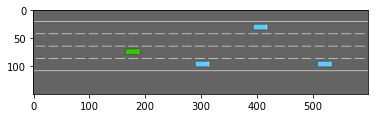

[[ 1.          0.89512116  0.5         0.3125      0.        ]
 [ 1.          0.11333414  0.25       -0.03701798  0.        ]
 [ 1.          0.20776689 -0.5        -0.03023216  0.        ]
 [ 1.          0.31213397  0.25       -0.03951356  0.        ]
 [ 1.          0.4182675   0.25       -0.02478336  0.        ]]

Acción: SLOWER -> recommpensa: 0.7338962090612631
Nuevo estado:


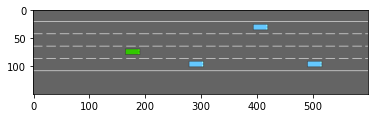

[[ 1.          1.          0.5         0.26068053  0.        ]
 [ 1.          0.10344059  0.25       -0.02369952  0.        ]
 [ 1.          0.20766953 -0.5         0.01707643  0.        ]
 [ 1.          0.29625803  0.25       -0.0449416   0.        ]
 [ 1.          0.4157067   0.25        0.00292857  0.        ]]

Acción: IDLE -> recommpensa: 0.7150048162755963
Nuevo estado:


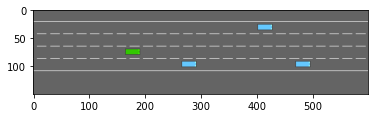

[[ 1.          1.          0.5         0.25182518  0.        ]
 [ 1.          0.09127475  0.25       -0.0382594   0.        ]
 [ 1.          0.21539019 -0.5         0.0199562   0.        ]
 [ 1.          0.27705762  0.25       -0.05035954  0.        ]
 [ 1.          0.41639867  0.19051379  0.00116071  0.0068297 ]]

Acción: SLOWER -> recommpensa: 0.7117764995128245
Nuevo estado:


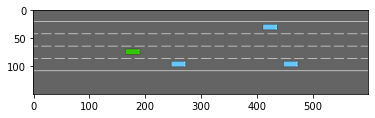

[[ 1.          1.          0.5         0.2503119   0.        ]
 [ 1.          0.07377376  0.25       -0.04893031  0.        ]
 [ 1.          0.22310118 -0.5         0.01837428  0.        ]
 [ 1.          0.2568481   0.25       -0.04990428  0.        ]
 [ 1.          0.41629684  0.24357204 -0.00128436  0.00690573]]

Acción: IDLE -> recommpensa: 0.7112248181604207
Nuevo estado:


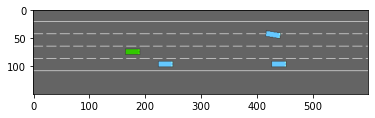

[[ 1.0000000e+00  1.0000000e+00  5.0000000e-01  2.5005329e-01
   0.0000000e+00]
 [ 1.0000000e+00  5.3109825e-02  2.5000000e-01 -5.3894091e-02
   0.0000000e+00]
 [ 1.0000000e+00  2.2905791e-01 -3.3942160e-01  1.3544834e-02
   4.5214247e-02]
 [ 1.0000000e+00  2.3752645e-01  2.5000000e-01 -4.6090484e-02
   0.0000000e+00]
 [ 1.0000000e+00  4.1563424e-01  2.5268781e-01 -1.8872130e-03
  -1.5685475e-04]]

Acción: FASTER -> recommpensa: 0.8216787776912134
Nuevo estado:


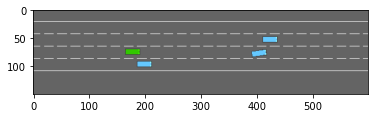

[[ 1.0000000e+00  1.0000000e+00  5.0000000e-01  3.0182859e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.8585088e-02  2.5000000e-01 -1.0456094e-01
   0.0000000e+00]
 [ 1.0000000e+00  2.0591427e-01  3.9398067e-02 -9.0680584e-02
  -3.2871269e-02]
 [ 1.0000000e+00  2.2358155e-01 -2.3902953e-01 -3.1847570e-02
   4.9774940e-03]
 [ 1.0000000e+00  4.0237984e-01  2.5036797e-01 -5.3211551e-02
  -3.3524662e-04]]

Acción: FASTER -> recommpensa: 0.9511022952260791
Nuevo estado:


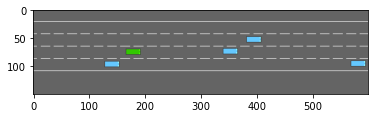

[[ 1.0000000e+00  1.0000000e+00  5.0000000e-01  3.6249587e-01
   0.0000000e+00]
 [ 1.0000000e+00 -3.4182549e-02  2.5000000e-01 -1.4606726e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.5870792e-01 -1.0687243e-02 -1.3412000e-01
  -8.8016025e-04]
 [ 1.0000000e+00  1.9645476e-01 -2.4528773e-01 -9.1001205e-02
  -2.2589760e-03]
 [ 1.0000000e+00  3.6657807e-01  2.4987796e-01 -1.1278320e-01
   2.3352361e-07]]

Acción: LANE_RIGHT -> recommpensa: 0.99544147387894
Nuevo estado:


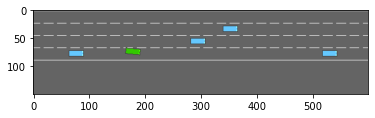

[[ 1.          1.          0.70893514  0.37124434  0.03470721]
 [ 1.          0.10553361 -0.21115391 -0.13294046 -0.03315984]
 [ 1.          0.15870315 -0.45944086 -0.09894822 -0.03498653]
 [ 1.          0.32019305  0.04104441 -0.12018761 -0.03469095]
 [ 1.          0.4547619  -0.20892191 -0.10392465 -0.03468269]]

Acción: IDLE -> recommpensa: 0.9992210015186749
Nuevo estado:


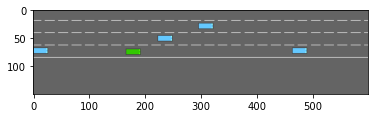

[[ 1.00000000e+00  1.00000000e+00  7.66010642e-01  3.74633849e-01
  -8.59223073e-04]
 [ 1.00000000e+00  5.26885055e-02 -2.65539229e-01 -1.29969716e-01
   9.32850002e-04]
 [ 1.00000000e+00  1.18253894e-01 -5.16257226e-01 -1.01936691e-01
   9.71352216e-04]
 [ 1.00000000e+00  2.71423250e-01 -1.60050932e-02 -1.22189604e-01
   8.59539141e-04]
 [ 1.00000000e+00  4.12273318e-01 -2.65994400e-01 -1.07209794e-01
   8.53632868e-04]]

Acción: LANE_LEFT -> recommpensa: 0.04444444444444443
Nuevo estado:


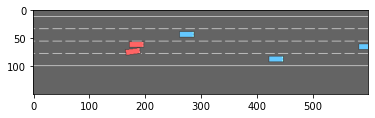

[[ 1.          1.          0.59430873  0.24526085 -0.03539939]
 [ 1.          0.00565269 -0.1466525  -0.08181284  0.03533989]
 [ 1.          0.08780003 -0.34428576  0.02761525  0.03541492]
 [ 1.          0.2330804   0.1556924   0.00851257  0.0353986 ]
 [ 1.          0.37962738 -0.09430914  0.02187242  0.03539807]]
Episodio terminado después de 9 pasos y la recompensa fue 6.683790335769457


In [7]:
obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = env.action_space.sample()
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.2 (0.5 ptos) - </strong> Explicar los diferentes espacios de observaciones y de acciones:
</div>

Resuelto en el informe

## 2. Agente de referencia